In [1]:


# %pip install pandasql
# %conda install pandasql 

import numpy as np
import pandas as pd
from pandasql import sqldf
import datetime


df = pd.read_csv('BoltTest.csv')

dff = pd.DataFrame(df)

#CREATE AND Clean the Datasets
query = '''SELECT     
    CASE
        WHEN duration < 600 THEN 'Short'
        WHEN duration >= 600 AND duration < 1800 THEN 'Medium'
        WHEN duration >= 1800 THEN 'Long'
        ELSE 'Unknown'
    END AS Duration_Type,
     (cast(upfront_price as float) - cast(metered_price as float)) AS Price_Difference,
     (cast(predicted_distance as float) - cast(distance as float)) AS Distance_Difference,
     (cast(predicted_duration as int) - cast(duration as float)) AS Duration_Difference,
     CASE 
         when ABS(cast(upfront_price as float) - cast(metered_price as float)) > 0.2*metered_price then 'metered_price'
         when ABS(cast(upfront_price as float) - cast(metered_price as float)) <= 0.2*metered_price then 'upfront_price'
         else 'metered_price' END AS FINAL_PRICE,
     
     CASE
        WHEN distance < 1000 THEN 'Short'
        WHEN distance >= 1000 AND distance < 5000 THEN 'Medium'
        WHEN distance >= 5000 THEN 'Long'
        ELSE 'Unknown' END AS Distance_Type,
* 
FROM dff
where metered_price < 10000 and duration < 7200; --Removing the Outliers

'''

result = sqldf(query)

#Drop unwanted fields
dff.drop(columns=['order_state','order_try_state','device_token'])

dff=print(result)
dff=pd.DataFrame(result)

     Duration_Type  Price_Difference  Distance_Difference  \
0           Medium              5.96              10545.0   
1            Short             -2.49              -3412.0   
2           Medium             -0.82               -325.0   
3            Short              0.19                -42.0   
4            Short              3.89               6525.0   
...            ...               ...                  ...   
3611        Medium             -1.41              -1897.0   
3612        Medium              2.81                500.0   
3613        Medium               NaN                  0.0   
3614         Short             -0.10               -162.0   
3615         Short              5.04               4615.0   

      Duration_Difference    FINAL_PRICE Distance_Type  order_id_new  \
0                   391.0  metered_price        Medium            22   
1                  -133.0  metered_price          Long           618   
2                  -262.0  upfront_price        Med

In [2]:
dff.to_csv('ajeet_bolt.csv',index=False) #Write new changes to new CSV file

print(dff.dtypes)


Duration_Type             object
Price_Difference         float64
Distance_Difference      float64
Duration_Difference      float64
FINAL_PRICE               object
Distance_Type             object
order_id_new               int64
order_try_id_new           int64
calc_created              object
metered_price            float64
upfront_price            float64
distance                   int64
duration                   int64
gps_confidence             int64
entered_by                object
b_state                   object
dest_change_number         int64
prediction_price_type     object
predicted_distance       float64
predicted_duration       float64
change_reason_pricing     object
ticket_id_new              int64
device_token              object
rider_app_version         object
order_state               object
order_try_state           object
driver_app_version        object
driver_device_uid_new      int64
device_name               object
eu_indicator               int64
overpaid_r

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate the percentage difference between upfront and metered prices
df = pd.read_csv('ajeet_bolt.csv')

# Calculate the absolute difference between upfront and metered prices
df['price_difference'] = df['upfront_price'] - df['metered_price']

# Visualize the distribution of price differences
plt.figure(figsize=(10, 6))
sns.histplot(df['price_difference'], bins=30, kde=True)
plt.title('Distribution of Price Differences')
plt.xlabel('Price Difference (Currency)')
plt.ylabel('Frequency')
plt.show()

# Identify cases where the difference is more than 20%
significant_difference_df = df[df['price_difference'].abs() > 0.2 * df['metered_price']]

# Display information about significant differences
significant_difference_df[['order_id_new', 'upfront_price', 'metered_price', 'price_difference']]




order_id_new  upfront_price  metered_price  price_difference
0               22           10.0           4.04              5.96
1              618            3.6           6.09             -2.49
4             1662            6.5           2.61              3.89
5             1999            2.5           4.14             -1.64
16             986            5.3           7.29             -1.99
...            ...            ...            ...               ...
3602          3831            6.9           9.61             -2.71
3607          2038            5.0           6.94             -1.94
3611          3236            5.6           7.01             -1.41
3612          3513           13.7          10.89              2.81
3615          3636            8.1           3.06              5.04

[1042 rows x 4 columns]

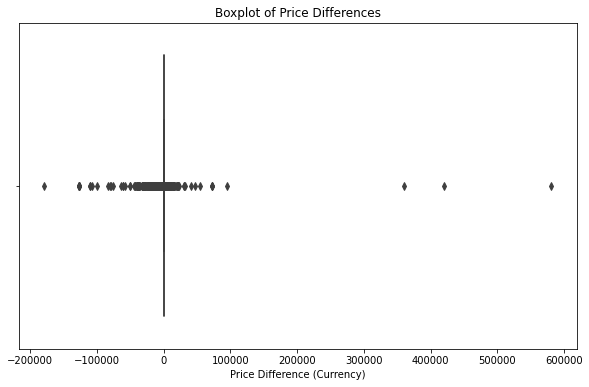

gps_confidence  avg_price_difference
0               0          -8795.812124
1               1            135.394942

entered_by  avg_price_difference
0     client           -851.909116
1     driver             -2.683529
2   reseller                   NaN

dest_change_number  avg_price_difference
0                   1          -1015.324562
1                   2          11619.855536
2                   3          -2388.913704
3                   4          -7358.816667
4                   5             -0.226667
5                   6                   NaN
6                   7             -8.750000
7                   9                   NaN
8                  12                   NaN

prediction_price_type  avg_price_difference
0                         None                   NaN
1                   prediction                   NaN
2                      upfront           -839.204362
3  upfront_destination_changed                   NaN
4     upfront_waypoint_changed                   NaN

In [8]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('BoltTest.csv')

# Calculate the absolute price difference
df['price_difference'] = df['upfront_price'] - df['metered_price']

# Visualize the distribution of price differences using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price_difference'])
plt.title('Boxplot of Price Differences')
plt.xlabel('Price Difference (Currency)')
plt.show()


# Define a function to run SQL queries
def run_query(query):
    return sqldf(query)

# SQL analysis: Factors contributing to discrepancies
queries = [
    # Average price difference for different values of gps_confidence
    "SELECT gps_confidence, AVG(upfront_price - metered_price) AS avg_price_difference FROM df GROUP BY gps_confidence;",
    
    # Average price difference for different values of entered_by
    "SELECT entered_by, AVG(upfront_price - metered_price) AS avg_price_difference FROM df GROUP BY entered_by;",
    
    # Average price difference for different values of dest_change_number
    "SELECT dest_change_number, AVG(upfront_price - metered_price) AS avg_price_difference FROM df GROUP BY dest_change_number;",
    
    # Average price difference for different values of prediction_price_type
    "SELECT prediction_price_type, AVG(upfront_price - metered_price) AS avg_price_difference FROM df GROUP BY prediction_price_type;"
]

# Run and display SQL queries
for query in queries:
    result = run_query(query)
    display(result)

# result = sqldf("SELECT gps_confidence, AVG(upfront_price - metered_price) AS avg_price_difference FROM df GROUP BY gps_confidence;")
# display(result)


In [9]:
df.corr()['upfront_price'].sort_values()

eu_indicator            -0.413250
gps_confidence          -0.206987
order_id_new            -0.192324
order_try_id_new        -0.192323
fraud_score             -0.075351
driver_device_uid_new   -0.026669
ticket_id_new           -0.006228
dest_change_number       0.051178
overpaid_ride_ticket     0.123028
distance                 0.167040
duration                 0.238937
metered_price            0.420772
price_difference         0.646448
predicted_distance       0.715542
predicted_duration       0.746837
upfront_price            1.000000
device_token                  NaN
Name: upfront_price, dtype: float64

In [10]:
df.corr()['metered_price'].sort_values()

eu_indicator            -0.568434
price_difference        -0.420123
gps_confidence          -0.403957
order_id_new            -0.075679
order_try_id_new        -0.075679
dest_change_number      -0.036261
driver_device_uid_new   -0.027712
fraud_score             -0.014472
ticket_id_new            0.037726
overpaid_ride_ticket     0.235677
predicted_distance       0.259371
upfront_price            0.420772
predicted_duration       0.448668
duration                 0.536198
distance                 0.539338
metered_price            1.000000
device_token                  NaN
Name: metered_price, dtype: float64

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('BoltTest.csv')


# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['metered_price']].sort_values(by='metered_price', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with metered_price')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('BoltTest.csv')


# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['upfront_price']].sort_values(by='upfront_price', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with Upfront Price')
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset

df = pd.read_csv('ajeet_bolt.csv')
#df = pd.read_csv('BoltTest.csv')


# Calculate the absolute price difference
df['price_difference'] = df['upfront_price'] - df['metered_price']

# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [17]:
#Heatmap from searborn library
df_corr = dff.corr()
sns.heatmap(df_corr, cmap =sns.color_palette("Set3"),annot = True)
plt.title("CORRELATION BETWEEN VARIABLES")

Text(0.5, 1.0, 'CORRELATION BETWEEN VARIABLES')